# <center>m-Generalized uniform scenario - Numerical integration</center>

$$ \left. \begin{array}{r} \left.\begin{array}{} 1 \\ \vdots \\ \alpha_{0,0} \end{array}\right\} \alpha_{0,0} \\ \vdots \\ \vdots \} \alpha_{0,m_1-1}\\\end{array} \right\} C_1, \quad \dots \quad, \left. \begin{array}{} \alpha_{m,0} \\ \vdots \\ \alpha_{m,m_m-1}\\\end{array} \right\}C_m$$

$C_i$ is representend by a coalition of $k_i=\sum_{j=0}^{m_i-1}\alpha_{i,j}$ uniform valuing bidders, we use the methods available in the notebook : *$m$-Generalized uniform scenario - Methods*

We compute the following utilities :

$$ \begin{array}{}
U_i &=& \mathbb{E}\left[ (V_i-\phi_i(V_i)) \cdot \mathbb{1}_{\{\phi_i(V_i)\geq \max_{j\neq i}\phi_j(V_j) \}} \right] \text{ where } V_i \sim \text{Beta}(k_i,1) \text{ for } i=0,\dots,m-1 \\ 
& = &\int_0^1(v-\phi_i(v)) \cdot \prod_{j\neq i} \lambda_j(\phi_i(v))^{k_j} \cdot k_i v^{k_i-1} dv 
\end{array}$$


$$ \begin{array}{rl}
U_{ij} &=& \mathbb{E}\left[ (V_{ij}-\phi_i(V_{ij})) \cdot \mathbb{1}_{V_{ij} \geq V_{i,-j}} \cdot \mathbb{1}_{\{\phi_i(V_{ij})\geq \max_{l\neq i}\phi_l(V_l) \}} \right] \text{ where } V_{ij} \sim \text{Beta}(\alpha_{ij},1), V_{i,-j} \sim \text{Beta}(k_j-\alpha_{ij},1) \text{ and } V_l \sim \text{Beta}(k_l,1) \text{ for } l\neq i \\
&=& \int_0^1(v-\phi_i(v)) \cdot v^{k_j-\alpha_{ij}} \cdot \prod_{l\neq i} \lambda_l(\phi_i(v))^{k_l} \cdot \alpha_{ij} v^{\alpha_{ij}-1} dv \\
&=& \frac{\alpha_{ij}}{k_i} U_i 
\end{array}$$


## <center>Python methods</center>

### Import, display and stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from matplotlib.colors import SymLogNorm

from scipy import integrate

from tqdm.notebook import tqdm
import time

In [2]:
#def value_f(b,i,out) :
#    b = min(max(b,0),out['tstar'])
#    l_ind = int((b/out['tstar'])*(out['N']+1))
#    v = out['values_'][i][l_ind] + (b-l_ind*out['tstar']/(out['N']+1))/out['tstar']#*(out['values_'][i][min(l_ind+1,out['N']+1)]-out['values_'][i][l_ind])
#    return v

#def bid_f(v,i,out) :
#    v = min(max(v,0),1)
#    l_ind = np.searchsorted(out['values_'][i],v,side='right')-1
#    b = l_ind/(out['N']+1)*out['tstar'] + (v-out['values_'][i][l_ind])*out['tstar']
#    return b

In [51]:
def value_f(b,i,out) :
    return np.interp(b,np.linspace(0,out['tstar'],out['N']+2),out['values_'][i])

def bid_f(v,i,out) :
    return np.interp(v,out['values_'][i],np.linspace(0,out['tstar'],out['N']+2))

In [4]:
def display_mGU(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coalitions {}".format(out['k_']))
    
    plt.subplot(131)
    v_ = np.linspace(0,1,1001)
    
    for i in range(out['m']) :
        plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta_'][i],'b',label=r'$\delta_{}$'.format(i))
        plt.axhline(out['l_'][i],color='b',linestyle='--')
        
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    #plt.ylim((min(out['l2_star'],out['l1_star'])-0.1,max(out['l2_star'],out['l1_star'])+0.1))
    plt.title(r"Approximated functions : $\delta_i(t) = \lambda_i(t)/t$")
    plt.legend()
    
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    
    for i in range(out['m']) :
        plt.plot(b_,out['values_'][i],'b',label=r'$\lambda_{}$'.format(i))
        plt.plot(b_,out['l_'][i]*b_,'b--')
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    
    plt.subplot(133)    
    for i in range(out['m']) :
        plt.plot(v_,[bid_f(v,i,out) for v in v_],'b',label=r"$\phi_{}$".format(i))
        plt.plot(v_,1/out['l_'][i]*v_,'b--')
        
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

### Shooting and Iterate methods

In [27]:
def shoot_mGU(tstar,k_,N=10_000,correct=True) : 
    k_ = np.array(k_)
    m = len(k_)
    
    if(np.any(k_==0)) :
        print("Given coalition sizes",k_)
        print("\terror every coalition size should be != 0")
        return

    delta_ = np.zeros((m,N+2))
    
    l_ = 1+1/(np.sum(k_)-k_)
    
    output = {}
    output['m'] = m
    output['tstar'] = tstar
    output['N'] = N
    output['breakpoint'] = 0
    output['l_'] = l_
    output['k_'] = k_
    
    A_inv = 1/(m-1)*((np.ones((m,m))-np.eye(m))-(m-2)*np.eye(m))
    
    eps_f = lambda i : np.linalg.norm(delta_[:,i]-l_,2)
    
    delta_[:,N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
        tjm1 = tstar*(j-1)/(N+1)
        
        #A = np.ones((m,m))-np.eye(m)
        #y = np.array([ 1/(delta_[i,j]-1) - (np.sum(k_)-k_[i]) for i in range(m)])
        #x = np.linalg.solve(A,y)
        #delta_p_[:,j] = delta_[:,j]/(tj*k_)*x
        
        y = 1/(delta_[:,j]-1) - (np.sum(k_)-k_)
        x = A_inv@y
        
        #deltap_j_ = delta_[:,j]/(tj*k_)*x
        #delta_[:,j-1] = delta_[:,j]+(tjm1-tj)*deltap_j_
        
        delta_[:,j-1] = delta_[:,j]*(1-x/(j*k_))
        
        if(output['breakpoint'] == 0 and eps_f(j-1) > eps_f(j) ) :
            output['breakpoint'] = j
            if(correct) :
                break

    output['eps_star'] = eps_f(output['breakpoint'])
    if(correct) :
        ind = output['breakpoint']
        for i in range(m) :
            delta_[i,:ind+1] = np.linspace(l_[i],delta_[i,ind],ind+1)
        
    output['delta_'] = delta_
    output['values_'] = np.zeros_like(delta_)
    output['values_'] = np.linspace(0,tstar,N+2)*delta_
        
    return output

In [6]:
def iterate_mGU(k_,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    if(np.any(k_==0)) :
        print("Every coalition size should be != 0")
        return
    
    k_ = np.array(k_)
    m = len(k_)
    
    l_ = 1+1/(np.sum(k_)-k_)
    
    a = 1/np.max(l_)
    b = 1/np.min(l_)
                 
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = shoot_mGU(x_1,k_,N=N,correct=correct)
    
    x_2 = a + tau*(b-a)
    f_2 = shoot_mGU(x_2,k_,N=N,correct=correct)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = shoot_mGU(x_2,k_,N=N,correct=correct)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = shoot_mGU(x_1,k_,N=N,correct=correct)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(f_1['eps_star']<f_2['eps_star']) :
            print("tstar :",f_1['tstar'])
        else :
            print("tstar :",f_2['tstar'])
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
            
    if(f_1['eps_star']<f_2['eps_star']) :
        if(display_graphs) :
            display_mGU(f_1)
        return f_1
    else :
        if(display_graphs) :
            display_mGU(f_2)
        return f_2

### Scenarios

In [7]:
def scenario_mGU(alpha_,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    
    m = len(alpha_)
    k_ = [np.sum(alpha_[i])  for i in range(m)]
    
    out = iterate_mGU(k_,eps=eps,nb_eval_max=nb_eval_max,N=N,show_msg=show_msg,display_graphs=display_graphs,correct=correct)
    
    b_ = np.linspace(0,out['tstar'],N+2)
    
    def integrand_coal(i,v) :
        res = v-bid_f(v,i,out)
        phi_i_v = bid_f(v,i,out)
        for j in range(m) :
            if(j!=i) :
                res *= value_f(phi_i_v,j,out)**k_[j]
        res *= k_[i]*v**(k_[i]-1)
        return res
    
    res = {'coal_':[] , 'coal__':[]}
    
    for i in range(m) :
        integrand = lambda v : integrand_coal(i,v)
        res['coal_'].append( integrate.quad(integrand, 0, 1, limit=10_000, epsabs=10**-15,epsrel=10**-15)[0] )
        res['coal__'].append( np.array(alpha_[i])/k_[i]*res['coal_'][i] )
    
    return res

### Basic tests

#### [Marshall1994] Table III page 211 : Coalition vs ***Coalition***

In [52]:
k = 1; n = 5
k_ = np.arange(1,n)

for k in tqdm(k_) :
    out = scenario_mGU([np.ones(k),np.ones(n-k)],eps=10**-5)
    
    print("k {} | in {:.10f} | out {:.10f}".format(k,out['coal__'][0][0],out['coal__'][1][0]))

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


k 1 | in 0.0856531181 | out 0.0568194235
k 2 | in 0.0521285033 | out 0.0467858145
k 3 | in 0.0467858145 | out 0.0521285033
k 4 | in 0.0568194235 | out 0.0856531181



#### [Marshall1994] Table III page 211 : Coalition vs ***Individuals***

In [53]:
k = 1; n = 5
k_ = np.arange(1,n)

for k in tqdm(k_) :
    alpha_ = [np.ones(k)]
    for i in range(n-k) :
        alpha_.append([1])

    out = scenario_mGU(alpha_,eps=10**-5)
    
    print("k {} | in {:.10f} | out {:.10f}".format(k,out['coal__'][0][0],out['coal__'][1][0]))

k 1 | in 0.0333333333 | out 0.0333333333


/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


k 2 | in 0.0349836630 | out 0.0371584708
k 3 | in 0.0406771206 | out 0.0486512592
k 4 | in 0.0568194235 | out 0.0856531181



## <center> Large test</center>

For different strength values $\alpha=\frac{1}{19}, \frac{1}{9}, \frac{1}{4}, \frac{1}{2}, 1, 3, 9$ which corresponds to the strong agents with average values of : $\frac{1}{20},\frac{1}{10}, \frac{1}{5}, \frac{1}{3}, \frac{1}{2}, \frac{3}{4}$. (...)

In [20]:
res_ = {}

In [54]:
alpha_ = [1/2]#[1/19,1/9,1/4,1/2,1,3,9]
n_ = np.arange(3,16)

for alpha in tqdm(alpha_) :
    res_[alpha] = np.ones((len(n_),n_[-1]-2))*np.nan
    for n in tqdm(n_) :
        for ks in np.arange(2,n) :
            
            alpha1_ = [[alpha]*ks]
            for i in range(n-ks) :
                alpha1_.append([1])
                
            alpha2_ = [[alpha],[alpha]*(ks-1)]
            for i in range(n-ks) :
                alpha2_.append([1])
            
            res_[alpha][n-3][ks-2] = scenario_mGU(alpha1_)['coal__'][0][0]-scenario_mGU(alpha2_)['coal__'][0][0]
                                                   

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [60]:
#emin = [np.floor(np.log10(np.min(np.where(np.isnan(res_[alpha]),np.inf,np.abs(res_[alpha]))))) for alpha in alpha_]
emin = -8#min(emin)

emax = [np.ceil(np.log10(np.max(np.where(np.isnan(res_[alpha]),-np.inf,np.abs(res_[alpha]))))) for alpha in alpha_]
emax = max(emax)
emax = -1.0 #WARNING

cbar_ticks = np.zeros(1)
cbar_ticks = np.append(-np.flip(np.power(10,np.arange(emin,emax+1))),cbar_ticks)
cbar_ticks = np.append(cbar_ticks,np.power(10,np.arange(emin,emax+1)))

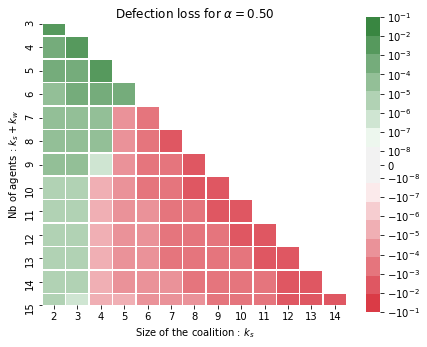

In [61]:
i = 1
plt.figure(figsize=(15,25))

for alpha in alpha_ :
    plt.subplot(4,2,i)
    sns.heatmap(res_[alpha],
                yticklabels=n_,xticklabels=n_-1,
                vmin = -10**emax, vmax=10**emax,
                mask=np.isnan(res_[alpha]),center=0,
                norm=SymLogNorm(linthresh=10**emin),
                cbar_kws={"ticks": cbar_ticks},
                cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
                square=True,linewidths=.5)
    plt.title(r"Defection loss for $\alpha={:.2f}$".format(alpha))
    plt.ylabel(r"Nb of agents : $k_s+k_w$")
    plt.xlabel(r"Size of the coalition : $k_s$")
    i=i+1

plt.show()

## <center>New set of tests</center>
----

## Test 1
* <font color=green>$\alpha$-agent</font>  : $ v \sim \text{Beta}(\alpha,1), \; \mathbb{E}(v)=\frac{\alpha}{\alpha+1}$, considers cooperating or not
* <font color=blue>1-agent</font> : $ v \sim \text{Unif}[0,1], \; \mathbb{E}(v)=1/2 $, considers cooperating or not
* external exogenous agent : $ v \sim \text{Unif}[0,1], \; \mathbb{E}(v)=1/2 $ do not cooperate

# $$ \{\color{green}{\alpha} \} \text{ vs } \{ \color{blue}{1} \} \text{ vs } \{1\} \quad \rightarrow_\text{collusion} \quad \left\{ \begin{array}{} \color{green}{\alpha} \\ \color{blue}{1} \end{array}\right\} \text{ vs } \{1\} $$

In [320]:
alpha_u_ = [[],[]]
one_u_ = [[],[]]

esp_ = np.linspace(0.01,0.99,21)
alpha_ = esp_/(1-esp_)

for alpha in tqdm(alpha_) :
    setup0_ = [[alpha],[1],[1]]
    setup1_ = [[alpha,1],[1]]
    
    out0 = scenario_mGU(setup0_,eps=10**-6)
    out1 = scenario_mGU(setup1_,eps=10**-6)
    
    alpha_u_[0].append(out0['coal__'][0][0])
    alpha_u_[1].append(out1['coal__'][0][0])
    
    one_u_[0].append(out0['coal__'][1][0])
    one_u_[1].append(out1['coal__'][0][1])

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [323]:
pickle.dump(alpha_,open("t1_E6_a_1_1_alpha_.pickle","wb"))
pickle.dump(alpha_u_,open("t1_E6_a_1_1_alpha_u_.pickle","wb"))
pickle.dump(one_u_,open("t1_E6_a_1_1_one_u_.pickle","wb"))

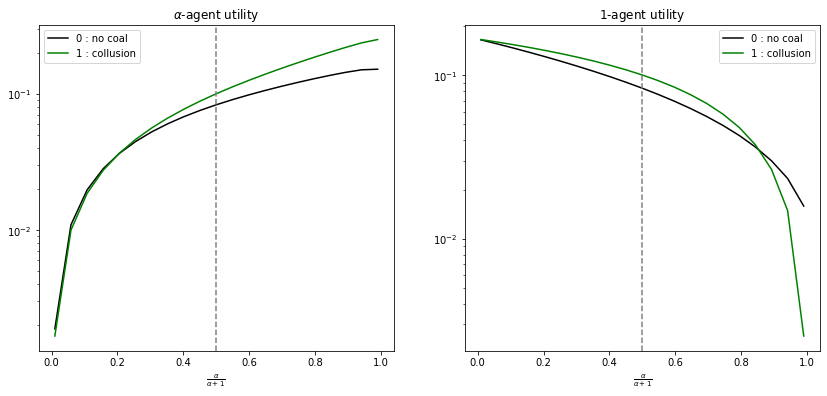

In [325]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.semilogy(esp_,alpha_u_[0],color='k',label="0 : no coal")
plt.semilogy(esp_,alpha_u_[1],color='g',label=r"1 : collusion")

plt.axvline(1/2,linestyle='--',color='gray')

plt.title(r"$\alpha$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.subplot(1,2,2)
plt.semilogy(esp_,one_u_[0],color='k',label="0 : no coal")
plt.semilogy(esp_,one_u_[1],color='g',label=r"1 : collusion")

plt.axvline(1/2,linestyle='--',color='gray')

plt.title(r"$1$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.show()

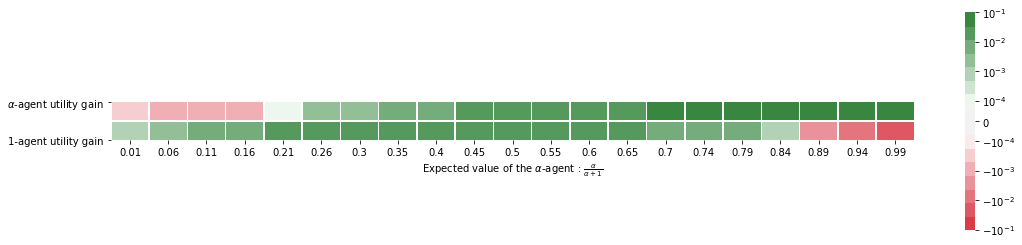

In [328]:
data = [np.array(alpha_u_[1])-np.array(alpha_u_[0]),np.array(one_u_[1])-np.array(one_u_[0])]

thresh = 10**np.floor(np.log10(np.min(np.abs(data))))
vsym = 10**np.ceil(np.log10(np.max(np.abs(data))))

cbar_ticks = np.zeros(1)
cbar_ticks = np.append(-np.flip(np.power(10,np.arange(emin,emax+1))),cbar_ticks)
cbar_ticks = np.append(cbar_ticks,np.power(10,np.arange(emin,emax+1)))

plt.figure(figsize=(18,4))
sns.heatmap(data,
            xticklabels=np.round(esp_,2),
            yticklabels=[r"$\alpha$-agent utility gain",r"1-agent utility gain"],
            vmin = -vsym, vmax=vsym,
            center=0,
            norm=SymLogNorm(linthresh=thresh),
            cbar_kws={"ticks": cbar_ticks},
            cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
            square=True,linewidths=.5)
plt.xlabel(r"Expected value of the $\alpha$-agent : $\frac{\alpha}{\alpha+1}$")
plt.show()

## Test 1 : Results
* <font color=green>$\alpha$-agent</font>  : $ v \sim \text{Beta}(\alpha,1), \; \mathbb{E}(v)=\frac{\alpha}{\alpha+1}$, considers cooperating or not
* <font color=blue>1-agent</font> : $ v \sim \text{Unif}[0,1], \; \mathbb{E}(v)=1/2 $, considers cooperating or not
* external exogenous agent : $ v \sim \text{Unif}[0,1], \; \mathbb{E}(v)=1/2 $ do not cooperate

# $$ \{\color{green}{\alpha} \} \text{ vs } \{ \color{blue}{1} \} \text{ vs } \{1\} \quad \rightarrow_\text{collusion} \quad \left\{ \begin{array}{} \color{green}{\alpha} \\ \color{blue}{1} \end{array}\right\} \text{ vs } \{1\} $$


* If $\alpha$-agent is too weak (expected value $\leq 0.2$)
    * $\alpha$-agent prefer defection
    * 1-agent prefer colluding
    * no equilibrium, every situation is unprofitable for someone
* If $\alpha$-agent's strength is near $1$-agent's (expected value $\in [0.2;0.8]$)
    * both $\alpha$-agent and 1-agent prefer colluding
    * equilbrium, collusion is profitable for both
    
* Symetrically, if $\alpha$-agent is too strong (expected value $\geq 0.8$)
    * $\alpha$-agent prefer colluding
    * 1-agent prefer leaving
    * no equilbrium, every situation is unprofitable for someone

----

## Test 1.1 : less homogenous variant

* external agent : $ v \sim \text{Beta}(0.5,1), \; \mathbb{E}(v)=0.333 $ do not cooperate


* <font color=green>$\alpha$-agent</font>  : $ v \sim \text{Beta}(\alpha,1), \; \mathbb{E}(v)=\frac{\alpha}{\alpha+1}$, considers cooperating or not
* <font color=blue>2-agent</font> : $ v \sim \text{Beta}(2,1), \; \mathbb{E}(v)=0.666 $, considers cooperating or not

# $$ \{\color{green}{\alpha} \} \text{ vs } \{ \color{blue}{2} \} \text{ vs } \{0.5\} \quad \rightarrow_\text{collusion} \quad \left\{ \begin{array}{} \color{green}{\alpha} \\ \color{blue}{2} \end{array}\right\} \text{ vs } \{0.5 \} $$

In [329]:
alpha_u_ = [[],[]]
one_u_ = [[],[]]

esp_ = np.linspace(0.01,0.99,21)
alpha_ = esp_/(1-esp_)

for alpha in tqdm(alpha_) :
    setup0_ = [[alpha],[2],[1/2]]
    setup1_ = [[alpha,2],[1/2]]
    
    out0 = scenario_mGU(setup0_,eps=10**-6)
    out1 = scenario_mGU(setup1_,eps=10**-6)
    
    alpha_u_[0].append(out0['coal__'][0][0])
    alpha_u_[1].append(out1['coal__'][0][0])
    
    one_u_[0].append(out0['coal__'][1][0])
    one_u_[1].append(out1['coal__'][0][1])

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [330]:
pickle.dump(alpha_,open("t11_E6_a_2_05_alpha_.pickle","wb"))
pickle.dump(alpha_u_,open("t11_E6_a_2_05_alpha_u_.pickle","wb"))
pickle.dump(one_u_,open("t11_E6_a_2_05_one_u_.pickle","wb"))

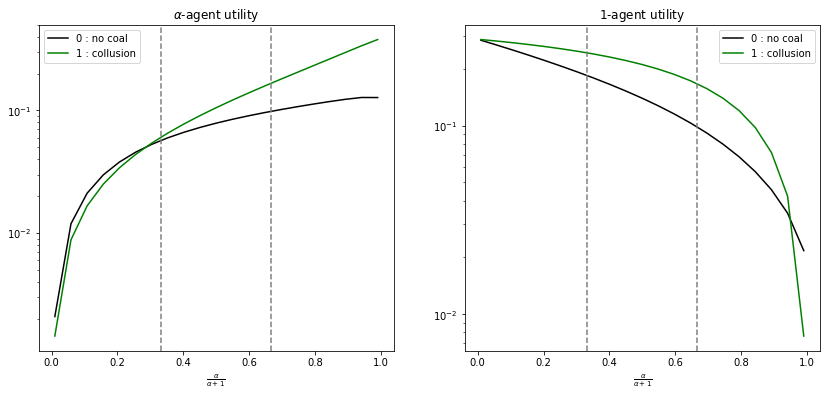

In [332]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.semilogy(esp_,alpha_u_[0],color='k',label="0 : no coal")
plt.semilogy(esp_,alpha_u_[1],color='g',label=r"1 : collusion")

plt.axvline(1/3,linestyle='--',color='gray')
plt.axvline(2/3,linestyle='--',color='gray')

plt.title(r"$\alpha$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.subplot(1,2,2)
plt.semilogy(esp_,one_u_[0],color='k',label="0 : no coal")
plt.semilogy(esp_,one_u_[1],color='g',label=r"1 : collusion")

plt.axvline(1/3,linestyle='--',color='gray')
plt.axvline(2/3,linestyle='--',color='gray')

plt.title(r"$1$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.show()

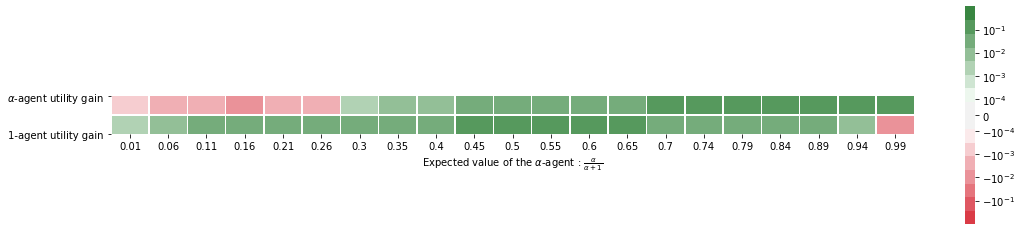

In [333]:
data = [np.array(alpha_u_[1])-np.array(alpha_u_[0]),np.array(one_u_[1])-np.array(one_u_[0])]

thresh = 10**np.floor(np.log10(np.min(np.abs(data))))
vsym = 10**np.ceil(np.log10(np.max(np.abs(data))))

cbar_ticks = np.zeros(1)
cbar_ticks = np.append(-np.flip(np.power(10,np.arange(emin,emax+1))),cbar_ticks)
cbar_ticks = np.append(cbar_ticks,np.power(10,np.arange(emin,emax+1)))

plt.figure(figsize=(18,4))
sns.heatmap(data,
            xticklabels=np.round(esp_,2),
            yticklabels=[r"$\alpha$-agent utility gain",r"1-agent utility gain"],
            vmin = -vsym, vmax=vsym,
            center=0,
            norm=SymLogNorm(linthresh=thresh),
            cbar_kws={"ticks": cbar_ticks},
            cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
            square=True,linewidths=.5)
plt.xlabel(r"Expected value of the $\alpha$-agent : $\frac{\alpha}{\alpha+1}$")
plt.show()

## Test 1.1 : less homogenous variant

* external agent : $ v \sim \text{Beta}(0.5,1), \; \mathbb{E}(v)=0.333 $ do not cooperate


* <font color=green>$\alpha$-agent</font>  : $ v \sim \text{Beta}(\alpha,1), \; \mathbb{E}(v)=\frac{\alpha}{\alpha+1}$, considers cooperating or not
* <font color=blue>2-agent</font> : $ v \sim \text{Beta}(2,1), \; \mathbb{E}(v)=0.666 $, considers cooperating or not

# $$ \{\color{green}{\alpha} \} \text{ vs } \{ \color{blue}{2} \} \text{ vs } \{0.5\} \quad \rightarrow_\text{collusion} \quad \left\{ \begin{array}{} \color{green}{\alpha} \\ \color{blue}{2} \end{array}\right\} \text{ vs } \{0.5 \} $$

* Same results as before (Test 1), the threshold of strength moves.

----

----

## Test 2 : the ring comes with a strong agent
* 0.5-weak agent external : $ v \sim \text{Beta}(0.5,1), \; \mathbb{E}(v)=0.333 $ do not cooperate
* 2-strong agent within the ring : $ v \sim \text{Beta}(2,1), \; \mathbb{E}(v)=0.666 $ always cooperate


* <font color=green>$\alpha$-agent</font>  : $ v \sim \text{Beta}(\alpha,1), \; \mathbb{E}(v)=\frac{\alpha}{\alpha+1}$, considers cooperating or not
* <font color=blue>1-agent</font> : $ v \sim \text{Unif}[0,1], \; \mathbb{E}(v)=0.5 $, considers cooperating or not

<br >

* ## (0) both play individually : $\{2\} \text{ vs }   \{\color{green}{\alpha} \} \text{ vs } \{ \color{blue}{1} \}  \text{ vs } \{0.5\}$

* ## (1) only $\alpha$-agent collude : $ \left\{ \begin{array}{} \color{green}{\alpha} \\ 2\end{array}\right\} \text{ vs } \{ \color{blue}{1} \} \text{ vs } \{0.5\}\quad$

* ## (2) only $1$-agent collude : $ \left\{ \begin{array}{} \color{blue}{1} \\ 2\end{array}\right\} \text{ vs }   \{\color{green}{\alpha} \}\text{ vs } \{0.5\}\quad$

* ## (3) both collude : $ \left\{ \begin{array}{} \color{green}{\alpha} \\ \color{blue}{1} \\ 2\end{array}\right\} \text{ vs } \{0.5\}\quad$

In [375]:
alpha_u_ = [[],[],[],[]]
one_u_ = [[],[],[],[]]

esp_ = np.linspace(0.01,0.99,41)
alpha_ = esp_/(1-esp_)

for alpha in tqdm(alpha_) :
    setup0_ = [[2],[alpha],[1],[1/2]]
    setup1_ = [[alpha,2],[1],[1/2]]
    setup2_ = [[1,2],[alpha],[1/2]]
    setup3_ = [[alpha,1,2],[1/2]]
    
    out0 = scenario_mGU(setup0_,eps=10**-6)
    out1 = scenario_mGU(setup1_,eps=10**-6)
    out2 = scenario_mGU(setup2_,eps=10**-6)
    out3 = scenario_mGU(setup3_,eps=10**-6)
    
    alpha_u_[0].append(out0['coal__'][1][0])
    alpha_u_[1].append(out1['coal__'][0][0])
    alpha_u_[2].append(out2['coal__'][1][0])
    alpha_u_[3].append(out3['coal__'][0][0])
    
    one_u_[0].append(out0['coal__'][2][0])
    one_u_[1].append(out1['coal__'][1][0])
    one_u_[2].append(out2['coal__'][0][0])
    one_u_[3].append(out3['coal__'][0][1])

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [318]:
#pickle.dump(alpha_,open("t2_E6_2_a_1_05_alpha_.pickle","wb"))
#pickle.dump(alpha_u_,open("t2_E6_2_a_1_05_alpha_u_.pickle","wb"))
#pickle.dump(one_u_,open("t2_E6_2_a_1_05_one_u_.pickle","wb"))

In [370]:
alpha_ = pickle.load(open("t2_E6_2_a_1_05_alpha_.pickle","rb"))
alpha_u_ = pickle.load(open("t2_E6_2_a_1_05_alpha_u_.pickle","rb"))
one_u_ = pickle.load(open("t2_E6_2_a_1_05_one_u_.pickle","rb"))

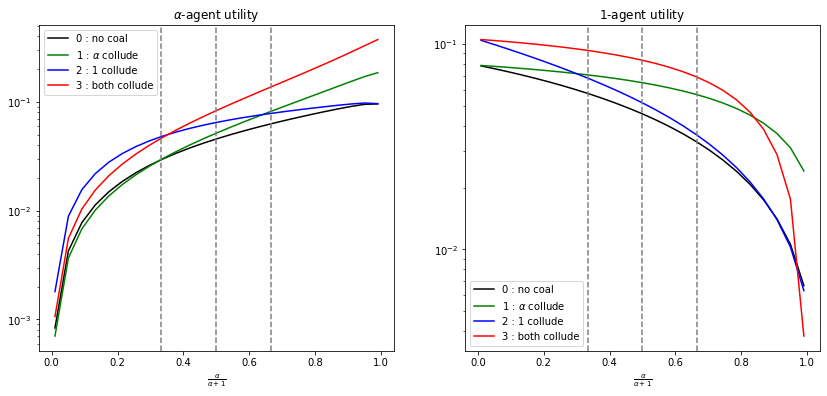

In [371]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.semilogy(esp_,alpha_u_[0],color='k',label="0 : no coal")
plt.semilogy(esp_,alpha_u_[1],color='g',label=r"1 : $\alpha$ collude")
plt.semilogy(esp_,alpha_u_[2],color='b',label=r"2 : 1 collude")
plt.semilogy(esp_,alpha_u_[3],color='r',label=r"3 : both collude")

plt.axvline(1/3,linestyle='--',color='gray')
plt.axvline(1/2,linestyle='--',color='gray')
plt.axvline(2/3,linestyle='--',color='gray')

plt.title(r"$\alpha$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.subplot(1,2,2)
plt.semilogy(esp_,one_u_[0],color='k',label="0 : no coal")
plt.semilogy(esp_,one_u_[1],color='g',label=r"1 : $\alpha$ collude")
plt.semilogy(esp_,one_u_[2],color='b',label=r"2 : 1 collude")
plt.semilogy(esp_,one_u_[3],color='r',label=r"3 : both collude")

plt.axvline(1/3,linestyle='--',color='gray')
plt.axvline(1/2,linestyle='--',color='gray')
plt.axvline(2/3,linestyle='--',color='gray')

plt.title(r"$1$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.show()

In [373]:
np.array(one_u_[2])-np.array(one_u_[0])

array([ 0.02595771,  0.02351089,  0.02122782,  0.01910357,  0.01713229,
        0.01530731,  0.01362134,  0.01206666,  0.01063534,  0.00931941,
        0.00811105,  0.00700266,  0.00598707,  0.00505757,  0.00420804,
        0.00343309,  0.00272816,  0.00208972,  0.00151551,  0.00100487,
        0.00055926,  0.00018323, -0.00011385, -0.00031303, -0.00036121])

In [374]:
np.array(one_u_[3])-np.array(one_u_[1])

array([ 0.02649241,  0.02610681,  0.02568935,  0.02523625,  0.02474314,
        0.02420492,  0.02361566,  0.02296839,  0.02225487,  0.02146534,
        0.02058811,  0.01960911,  0.0185113 ,  0.01727384,  0.01587105,
        0.014271  ,  0.01243358,  0.01030797,  0.00782916,  0.00491327,
        0.00145189, -0.00269372, -0.00769107, -0.01368708, -0.02030013])

## Test 2 : the ring comes with a strong agent - results
 
* if $\alpha$ is small ($\leq$ 0.5-external agent) :
    * $\alpha$-agent's prefered scenario : I act indivdually and $1$-agent collude $\{1, 2\}$ vs $\{\alpha\}$ vs $\{0.5\}$
    * 1-agent's prefered scenario : I collude with $\alpha$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * $\alpha$-agent defect & $1$-agent collude : $\{1, 2\}$ vs $\{\alpha\}$ vs $\{0.5\}$ is an EQUILBIRUM  made of DOMINANT strategies.
        * defection is DOMINANT for $\alpha$-agent
        * collusion is DOMINANT for 1-agent


* if $\alpha$-agent's strength is near $1$-agent's (avg value $\in [1/3,2/3]$) :
    * $\alpha$-agent's prefered scenario :  I collude with $1$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * 1-agent's prefered scenario : I collude with $\alpha$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * both collude : $\{1, \alpha, 2\}$ vs $\{0.5\}$  is an EQUILBRIUM made of DOMINANT strategies.
        * collusion is a DOMINANT strategy for both agent
    
    
* SYMMETRICALLY : if $\alpha$ is too high (avg value $\geq 0.85$)
    * $\alpha$-agent's prefered scenario :  I collude with $1$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * 1-agent's prefered scenario : I act indivdually and $\alpha$-agent collude $\{\alpha, 2\}$ vs $\{1\}$ vs $\{0.5\}$
    * 1-agent defect & $\alpha$-agent collude : $\{\alpha, 2\}$ vs $\{1\}$ vs $\{0.5\}$ is an EQUILBIRUM made of DOMINANT strategies.
        * collusion is DOMINANT for $\alpha$-agent
        * defection is DOMINANT for $1$-agent (if $\alpha$ big enough)

----

## Test 2.1 : the ring comes with a weak agent
* 0.5-weak agent within the ring : $ v \sim \text{Beta}(0.5,1), \; \mathbb{E}(v)=0.333 $ always cooperate
* 2-strong agent external : $ v \sim \text{Beta}(2,1), \; \mathbb{E}(v)=0.666 $ do not cooperate


* <font color=green>$\alpha$-agent</font>  : $ v \sim \text{Beta}(\alpha,1), \; \mathbb{E}(v)=\frac{\alpha}{\alpha+1}$, considers cooperating or not
* <font color=blue>1-agent</font> : $ v \sim \text{Unif}[0,1], \; \mathbb{E}(v)=0.5 $, considers cooperating or not

<br >

* ## (0) both play individually : $\{0.5\} \text{ vs }   \{\color{green}{\alpha} \} \text{ vs } \{ \color{blue}{1} \}  \text{ vs } \{2\}$

* ## (1) only $\alpha$-agent collude : $ \left\{ \begin{array}{} \color{green}{\alpha} \\ 0.5\end{array}\right\} \text{ vs } \{ \color{blue}{1} \} \text{ vs } \{2\}\quad$

* ## (2) only $1$-agent collude : $ \left\{ \begin{array}{} \color{blue}{1} \\ 0.5\end{array}\right\} \text{ vs }   \{\color{green}{\alpha} \}\text{ vs } \{2\}\quad$

* ## (3) both collude : $ \left\{ \begin{array}{} \color{green}{\alpha} \\ \color{blue}{1} \\ 0.5\end{array}\right\} \text{ vs } \{2\}\quad$

In [ ]:
alpha_u_ = [[],[],[],[]]
one_u_ = [[],[],[],[]]

esp_ = np.linspace(0.01,0.99,25)
alpha_ = esp_/(1-esp_)

for alpha in tqdm(alpha_) :
    setup0_ = [[1/2],[alpha],[1],[2]]
    setup1_ = [[alpha,1/2],[1],[2]]
    setup2_ = [[1,1/2],[alpha],[2]]
    setup3_ = [[alpha,1,1/2],[2]]
    
    out0 = scenario_mGU(setup0_,eps=10**-6)
    out1 = scenario_mGU(setup1_,eps=10**-6)
    out2 = scenario_mGU(setup2_,eps=10**-6)
    out3 = scenario_mGU(setup3_,eps=10**-6)
    
    alpha_u_[0].append(out0['coal__'][1][0])
    alpha_u_[1].append(out1['coal__'][0][0])
    alpha_u_[2].append(out2['coal__'][1][0])
    alpha_u_[3].append(out3['coal__'][0][0])
    
    one_u_[0].append(out0['coal__'][2][0])
    one_u_[1].append(out1['coal__'][1][0])
    one_u_[2].append(out2['coal__'][0][0])
    one_u_[3].append(out3['coal__'][0][1])

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [336]:
pickle.dump(alpha_,open("t21_E6_05_a_1_2_alpha_.pickle","wb"))
pickle.dump(alpha_u_,open("t21_E6_05_a_1_2_alpha_u_.pickle","wb"))
pickle.dump(one_u_,open("t21_E6_05_a_1_2_one_u_.pickle","wb"))

In [365]:
alpha_ = pickle.load(open("t21_E6_05_a_1_2_alpha_.pickle","rb"))
alpha_u_ = pickle.load(open("t21_E6_05_a_1_2_alpha_u_.pickle","rb"))
one_u_ = pickle.load(open("t21_E6_05_a_1_2_one_u_.pickle","rb"))

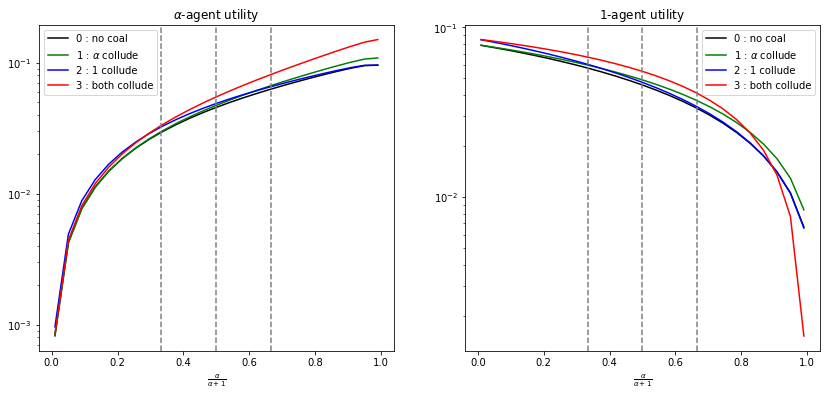

In [367]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.semilogy(esp_[6:-6],alpha_u_[0][6:-6],color='k',label="0 : no coal")
plt.semilogy(esp_[6:-6],alpha_u_[1][6:-6],color='g',label=r"1 : $\alpha$ collude")
plt.semilogy(esp_[6:-6],alpha_u_[2][6:-6],color='b',label=r"2 : 1 collude")
plt.semilogy(esp_[6:-6],alpha_u_[3][6:-6],color='r',label=r"3 : both collude")

plt.axvline(1/3,linestyle='--',color='gray')
plt.axvline(1/2,linestyle='--',color='gray')
plt.axvline(2/3,linestyle='--',color='gray')

plt.title(r"$\alpha$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.subplot(1,2,2)
plt.semilogy(esp_[6:-6],one_u_[0][6:-6],color='k',label="0 : no coal")
plt.semilogy(esp_[6:-6],one_u_[1][6:-6],color='g',label=r"1 : $\alpha$ collude")
plt.semilogy(esp_[6:-6],one_u_[2][6:-6],color='b',label=r"2 : 1 collude")
plt.semilogy(esp_[6:-6],one_u_[3][6:-6],color='r',label=r"3 : both collude")

plt.axvline(1/3,linestyle='--',color='gray')
plt.axvline(1/2,linestyle='--',color='gray')
plt.axvline(2/3,linestyle='--',color='gray')

plt.title(r"$1$-agent utility")
plt.xlabel(r"$\frac{\alpha}{\alpha+1}$")
plt.legend()

plt.show()

## Test 2.1 : the ring comes with a weak agent - results
 
* if $\alpha$ is small (expected value $\leq$ 0.25) :
    * $\alpha$-agent's prefered scenario : I act indivdually and $1$-agent collude $\{1, 2\}$ vs $\{\alpha\}$ vs $\{0.5\}$
    * 1-agent's prefered scenario : I collude with $\alpha$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * $\alpha$-agent defect & $1$-agent collude : $\{1, 2\}$ vs $\{\alpha\}$ vs $\{0.5\}$ is an EQUILBIRUM.
    

* if $\alpha$-agent's strength is near $1$-agent's (avg value $\in [1/3,2/3]$) :
    * $\alpha$-agent's prefered scenario :  I collude with $1$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * 1-agent's prefered scenario : I collude with $\alpha$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * both collude : $\{1, \alpha, 2\}$ vs $\{0.5\}$  is a EQUILBRIUM
        * collusion is a DOMINANT strategy for both agent
    
    
* SYMMETRICALLY : if $\alpha$ is too high (avg value $\geq 0.82$)
    * $\alpha$-agent's prefered scenario :  I collude with $1$-agent : $\{1, \alpha, 2\}$ vs $\{0.5\}$ 
    * 1-agent's prefered scenario : I act indivdually and $\alpha$-agent collude $\{\alpha, 2\}$ vs $\{1\}$ vs $\{0.5\}$
    * 1-agent defect & $\alpha$-agent collude : $\{\alpha, 2\}$ vs $\{1\}$ vs $\{0.5\}$ is an EQUILBIRUM.

----

## Test 3 : How to group the agents ?
# $$ \left\{ \begin{array}{} \alpha \\ \alpha \end{array}\right\} \text{ vs } \left\{ \begin{array}{} 1 \\ 1 \end{array} \right\} \quad \text{or} \quad \left\{ \begin{array}{} \alpha \\ 1 \end{array}\right\} \text{ vs } \left\{ \begin{array}{} \alpha \\ 1 \end{array} \right\} $$

**Remarks** : 
* The second scenario lead to iid Beta$(\alpha+1,1)$ coalitions $\rightarrow$ linear strategies

In [194]:
sum_u_diff_ = {}
alpha_u_diff_ = {}
one_u_diff_ = {}

esp_ = np.linspace(0.1,0.9,21)
alpha_ = esp_/(1-esp_)

for alpha in tqdm(alpha_) :
    setup1_ = [[alpha,alpha],[1,1]]
    setup2_ = [[alpha,1],[alpha,1]]
    
    out1 = scenario_mGU(setup1_,eps=10**-5)
    out2 = scenario_mGU(setup2_,eps=10**-5)
    
    sum_u_diff_[alpha] = np.sum(out1['coal_'])-np.sum(out2['coal_'])
    alpha_u_diff_[alpha] = out1['coal__'][0][0]-out2['coal__'][0][0]
    one_u_diff_[alpha] = out1['coal__'][1][1]-out2['coal__'][1][1]

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


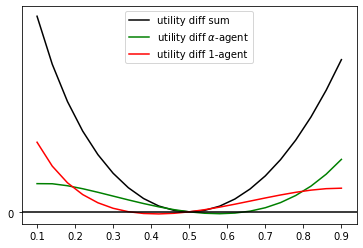

In [196]:
plt.plot(esp_,np.array(list(sum_u_diff_.values())),'k',label='utility diff sum')
plt.plot(esp_,np.array(list(alpha_u_diff_.values())),'g',label=r'utility diff $\alpha$-agent')
plt.plot(esp_,np.array(list(one_u_diff_.values())),'r',label=r'utility diff 1-agent')

plt.yscale("symlog")
plt.legend()
plt.axhline(0,color='k')
plt.show()

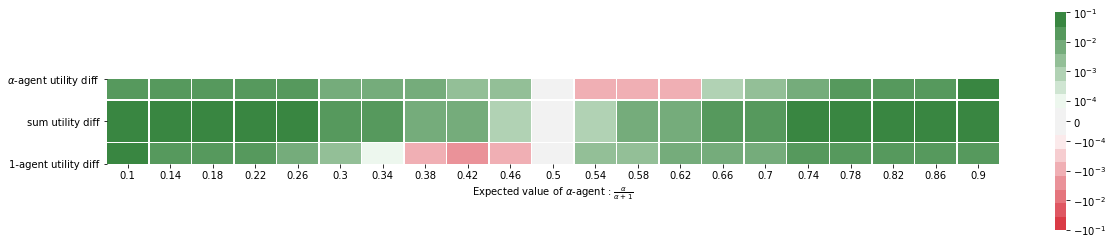

In [213]:
emin = -4.0; emax = -1.0;
cbar_ticks = np.zeros(1)
cbar_ticks = np.append(-np.flip(np.power(10,np.arange(emin,emax+1))),cbar_ticks)
cbar_ticks = np.append(cbar_ticks,np.power(10,np.arange(emin,emax+1)))

plt.figure(figsize=(20,4))
sns.heatmap([list(alpha_u_diff_.values()),list(sum_u_diff_.values()),list(one_u_diff_.values()) ],
            xticklabels=np.round(esp_,2),
            yticklabels=[r"$\alpha$-agent utility diff",r"sum utility diff",r"1-agent utility diff"],
            vmin = -10**emax, vmax=10**emax,
            center=0,
            norm=SymLogNorm(linthresh=10**emin),
            cbar_kws={"ticks": cbar_ticks},
            
            cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
            square=True,linewidths=.5)
plt.xlabel(r"Expected value of $\alpha$-agent : $\frac{\alpha}{\alpha+1}$")
plt.show()

## Numerical results 2
# $$ \left\{ \begin{array}{} \alpha \\ \alpha \end{array}\right\} \text{ vs } \left\{ \begin{array}{} 1 \\ 1 \end{array} \right\} \quad \text{or} \quad \left\{ \begin{array}{} \alpha \\ 1 \end{array}\right\} \text{ vs } \left\{ \begin{array}{} \alpha \\ 1 \end{array} \right\} $$

* Grouping agents by strength, leads to a greater overall utilty, whatever the strength.
* If the agents strength are close : the weak agents gain utility from the regrouping whereas the strong agents loose some utility.
* If the agents strength are distant : all the agents gain utility.